<a href="https://colab.research.google.com/github/rawar/tensorflow-notebooks/blob/master/m3_time_series_prediction2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predict stock prices with Long short-term memory (LSTM)
This simple example will show you how LSTM models predict time series data. Stock market data is a great choice for this because it's quite regular and widely available via the Internet.

### Install requirements
We install Tensorflow 2.0 nightly build with GPU and LSTM support first

In [1]:
#!pip install tensorflow-gpu==2.0.0-alpha0
pip install tf-nightly-gpu

     |████████████████████████████████| 375.3MB 42kB/s 
     |████████████████████████████████| 61kB 27.9MB/s 
     |████████████████████████████████| 3.1MB 30.9MB/s 
     |████████████████████████████████| 491kB 50.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
  Found existing installation: wrapt 1.10.11
    Uninstalling wrapt-1.10.11:
      Successfully uninstalled wrapt-1.10.11


In [0]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

### Loading the dataset
I use pandas-datareader to get the historical stock prices from Yahoo! finance. For this example, I get only the historical data till the end of training_end_data.

In [0]:
from pandas_datareader import data

In [0]:
tickers = 'AAPL'

#start_date = '1980-12-01'
start_date = '2016-12-01'
end_date = '2019-05-01'

stock_data = data.get_data_yahoo(tickers, start_date, end_date)

In [5]:
stock_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-12-01,110.940002,109.029999,110.370003,109.489998,37086900.0,105.304413
2016-12-02,110.089996,108.849998,109.169998,109.900002,26528000.0,105.698738
2016-12-05,110.029999,108.250000,110.000000,109.110001,34324500.0,104.938942
2016-12-06,110.360001,109.190002,109.500000,109.949997,26195500.0,105.746819
2016-12-07,111.190002,109.160004,109.260002,111.029999,29998700.0,106.785538


### Plot the whole data set

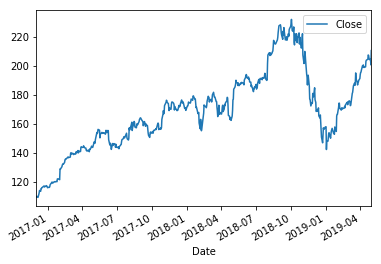

In [10]:
stock_data_frame = stock_data[["Close"]]
stock_data_frame.plot()

### Reindex dataset

Of course, some of the weekdays might be public holidays in which case no price will be available. For this reason, we will fill the missing prices with the latest available prices

In [0]:
all_businessdays = pd.date_range(start=start_date, end=end_date, freq='B')
stock_businessdays_data_frame = stock_data_frame.reindex(all_businessdays)
stock_businessdays_data_frame = stock_data_frame.fillna(method='ffill')

### Split the data set into training and test

The following code split the whole dataset into two different sets. First, the major part for training and the minor part for testing.

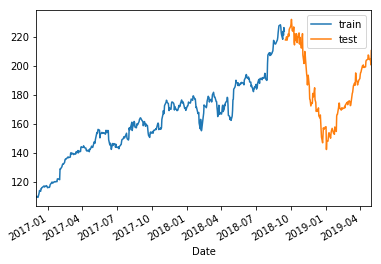

In [12]:
split_date = pd.Timestamp('2018-09-15')
train = stock_businessdays_data_frame.loc[:split_date]
test = stock_businessdays_data_frame.loc[split_date:]
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])


### Reshape input data

In [0]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [0]:

X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [0]:

X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

### Train the model

We're using the EarlyStopping() callback function to stop the training if no improvement after 5 epochs will be find. 

In [0]:
import tensorflow as tf

In [17]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(7, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

W0512 10:09:29.324509 139912364066688 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/200
449/449 [==============================] - 4s 10ms/sample - loss: 0.0100
Epoch 2/200
449/449 [==============================] - 2s 5ms/sample - loss: 0.0212
Epoch 3/200
449/449 [==============================] - 2s 4ms/sample - loss: 0.0121
Epoch 4/200
449/449 [==============================] - 2s 5ms/sample - loss: 0.0064
Epoch 5/200
449/449 [==============================] - 2s 4ms/sample - loss: 0.0032
Epoch 6/200
449/449 [==============================] - 2s 4ms/sample - loss: 0.0017
Epoch 7/200
449/449 [==============================] - 2s 5ms/sample - loss: 0.0011
Epoch 8/200
449/449 [==============================] - 2s 4ms/sample - loss: 8.2436e-04
Epoch 9/200
449/449 [==============================] - 2s 5ms/sample - loss: 7.0357e-04
Epoch 10/200
449/449 [==============================] - 2s 5ms/sample - loss: 6.4264e-04
Epoch 11/200
449/449 [==============================] - 2s 5ms/sample - loss: 6.0914e-04
Epoch 12/200
449/449 [==============================] - 2

### Calculate the model quality

We're using the R^2 to calculate the model quallity. R^2 is a quality measument to test regression models. If R^2 is  0 then there is no linear relationship between the data and the model, if R^2 is 1 then the model match perfectly

In [0]:
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [19]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

The R2 score on the Train set is:	0.974
The Adjusted R2 score on the Train set is:	0.974

The R2 score on the Test set is:	0.953
The Adjusted R2 score on the Test set is:	0.953


In [0]:
model_lstm.save('LSTM_NonShift_v2.h5')

In [21]:
model_lstm = tf.keras.models.load_model('LSTM_NonShift_v2.h5')

W0512 10:20:09.346816 139912364066688 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0512 10:20:09.348794 139912364066688 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0512 10:20:09.575395 139912364066688 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is de

In [22]:
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)

155/155 [==============================] - 1s 3ms/sample - loss: 0.0018


In [23]:
print('LSTM: %f'%score_lstm)

LSTM: 0.001848


In [0]:
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

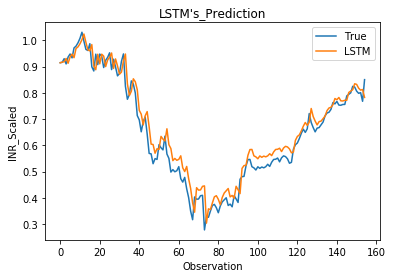

In [25]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()